# CSE473s Project

## Part 1 (XOR)
Implement our custom library, test it with [XOR] problem, validate it, and also implement the same exact problem using [TesnorFlow] or [Keras] then compare the results.

### Data initialization

In [1]:
import numpy as np

X = np.array([[-1, -1],[-1, 1],[1, -1],[1, 1]], dtype=np.float32)
y_true = np.array([[-1],[1],[1],[-1]], dtype=np.float32)

### Build netwrok with our custom library

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from lib import Sequential, Dense, Tanh, Sigmoid, ReLU, Softmax, MSELoss, SGDOptimizer as SGD

model = Sequential([
    Dense(2, 4, 0.1), Tanh(), Dense(4, 1, 0.1), Tanh()
])

opt = SGD(learning_rate=1.0)
loss_fn = MSELoss()

### Training loop

In [3]:
n_epochs = 10000

model.fit(X, y_true, loss_fn, opt, epochs=n_epochs)

Epoch 0, Loss: 0.5045193715936002
Epoch 100, Loss: 0.00485475934134631
Epoch 200, Loss: 0.0012866794715421727
Epoch 300, Loss: 0.0007112113976762955
Epoch 400, Loss: 0.0004848295108862886
Epoch 500, Loss: 0.0003653170169248814
Epoch 600, Loss: 0.0002919040644904718
Epoch 700, Loss: 0.00024241241622914762
Epoch 800, Loss: 0.0002068747095295946
Epoch 900, Loss: 0.00018016495062902845
Epoch 1000, Loss: 0.0001593839948339019
Epoch 1100, Loss: 0.0001427716571343814
Epoch 1200, Loss: 0.00012919880898740703
Epoch 1300, Loss: 0.00011790856121141947
Epoch 1400, Loss: 0.0001083749522365341
Epoch 1500, Loss: 0.00010022135553425666
Epoch 1600, Loss: 9.317113635611968e-05
Epoch 1700, Loss: 8.701662489650841e-05
Epoch 1800, Loss: 8.159894599986585e-05
Epoch 1900, Loss: 7.679452353663333e-05
Epoch 2000, Loss: 7.250582069557405e-05
Epoch 2100, Loss: 6.865484425964533e-05
Epoch 2200, Loss: 6.517849724666217e-05
Epoch 2300, Loss: 6.202519492556227e-05
Epoch 2400, Loss: 5.9152361441360015e-05
Epoch 2500,

### Assert correctness

In [35]:
y_pred = model.forward(X)

print("Raw preds:\n", y_pred)
print("Rounded:\n", np.int8(np.round(y_pred)))

y_test = model.forward([-2.0, 3.0])
print("\nTest with random input (e.g.; [-2.0, 3.0]):", np.int8(np.round(y_test)))

Raw preds:
 [[-0.07080107]
 [-0.08456789]
 [-0.08306429]
 [-0.09684827]]
Rounded:
 [[0]
 [0]
 [0]
 [0]]

Test with random input (e.g.; [-2.0, 3.0]): [[0]]


### Plotting
Plotting the classifier boundary layers

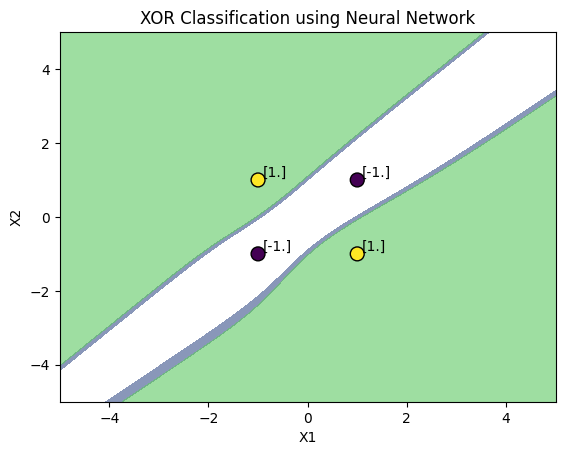

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of points for visualization
xx, yy = np.meshgrid(
    np.linspace(-5.0, 5.0, 200),
    np.linspace(-5.0, 5.0, 200)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]  # shape (40000, 2)

# Predict on the grid
Z = model.forward(grid_points)  # shape (40000, 1)
Z = Z.reshape(xx.shape)         # reshape to (200, 200)

# Plot classification regions
plt.contourf(xx, yy, Z, levels=[0,0.5,1], alpha=0.6)

# Plot XOR data points
plt.scatter(X[:, 0], X[:, 1], s=100, c=y_true, edgecolors='k')
for i, txt in enumerate(y_true):
    plt.text(X[i, 0] + 0.1, X[i, 1] + 0.1, str(txt))

plt.title("XOR Classification using Neural Network")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### Section (1) [Gradient-Checking]
Proving that our backpropagation is correct, by comparing its gradients with the gradients of numerical gradient descent.

#### Numerical gradient descent function

In [36]:
import numpy as np

def numerical_gradient(model, X, y_true, loss_fn, epsilon=1e-5):
    numerical_grads = []

    for layer in model.layers:
        layer_grads = []

        if layer.trainable:
            for param in layer.params:
                grad = np.zeros_like(param)

                it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
                while not it.finished:
                    idx = it.multi_index
                    original_value = param[idx]

                    param[idx] = original_value + epsilon
                    loss_plus = loss_fn(y_true, model.forward(X))

                    param[idx] = original_value - epsilon
                    loss_minus = loss_fn(y_true, model.forward(X))

                    grad[idx] = (loss_plus - loss_minus) / (2 * epsilon)

                    param[idx] = original_value
                    it.iternext()
                
                layer_grads.append(grad)
        
        numerical_grads.append(layer_grads)

    return numerical_grads

#### Testing & comparing between our backprop and numerical gradient

In [39]:

# Compute numerical gradients
numerical_grads = numerical_gradient(model, X, y_true, loss_fn)
print("\nNumerical Gradients:")
for layer_idx, layer in enumerate(model.layers):
    if layer.trainable:
        print(f"Layer {layer_idx} ({type(layer).__name__}):")
        for param_idx, param in enumerate(layer.params):
            print(f" Param {param_idx} gradient:\n{numerical_grads[layer_idx][param_idx]}")

# Compare with backprop gradients
model.forward(X)
model.backward(loss_fn.backward())
print("\nBackprop Gradients:")
for layer_idx, layer in enumerate(model.layers):
    if layer.trainable:
        print(f"Layer {layer_idx} ({type(layer).__name__}):")
        for param_idx, grad in enumerate(layer.grads):
            print(f" Param {param_idx} gradient:\n{grad}")

# Check if numerical and backprop gradients are close
tolerance = 1e-4
for layer_idx, layer in enumerate(model.layers):
    if layer.trainable:
        for param_idx in range(len(layer.params)):
            num_grad = numerical_grads[layer_idx][param_idx]
            backprop_grad = layer.grads[param_idx]
            print(f"\nDifference for Layer {layer_idx} Param {param_idx}:\n", num_grad - backprop_grad)
            if not np.allclose(num_grad, backprop_grad, atol=tolerance):
                print(f"Gradient check failed for Layer {layer_idx} Param {param_idx}")
            else:
                print(f"Gradient check passed for Layer {layer_idx} Param {param_idx}")


Numerical Gradients:
Layer 0 (Dense):
 Param 0 gradient:
[[-1.99459310e-04 -1.11517001e-03  7.12497888e-04  2.26926056e-04]
 [-1.62222857e-04 -4.16111695e-04  4.99503888e-04  6.28637864e-05]]
 Param 1 gradient:
[[-0.00190285 -0.00614967  0.01045856  0.00074449]]
Layer 2 (Dense):
 Param 0 gradient:
[[0.00170479]
 [0.00405783]
 [0.00249983]
 [0.00154079]]
 Param 1 gradient:
[[-0.08329532]]

Backprop Gradients:
Layer 0 (Dense):
 Param 0 gradient:
[[-1.99458982e-04 -1.11516979e-03  7.12499999e-04  2.26926272e-04]
 [-1.62222015e-04 -4.16104455e-04  4.99503054e-04  6.28623735e-05]]
 Param 1 gradient:
[[-0.00190308 -0.00615043  0.01045976  0.00074465]]
Layer 2 (Dense):
 Param 0 gradient:
[[0.00170497]
 [0.00405827]
 [0.00250018]
 [0.00154097]]
 Param 1 gradient:
[[-0.08330517]]

Difference for Layer 0 Param 0:
 [[-3.27872860e-10 -2.23025255e-10 -2.11005280e-09 -2.16464575e-10]
 [-8.42817085e-10 -7.23987746e-09  8.34613809e-10  1.41293324e-09]]
Gradient check passed for Layer 0 Param 0

Diffe

### Section (3) [Autoencoder]

In [1]:
import numpy as np
import sys, os
sys.path.insert(0, os.path.abspath('..')) 

from lib import Sequential, Dense, ReLU, Sigmoid, MSELoss, SGDOptimizer as SGD
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', version=1, as_frame=False) 
X_mnist = mnist.data.astype(np.float32) / 255.0
y_mnist = mnist.target.astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_mnist, test_size=0.2, random_state=42)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/mostafa/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [9]:
# 3. Define Autoencoder
autoencoder = Sequential([
    Dense(784, 128, 0.1), ReLU(),
    Dense(128, 64, 0.1), ReLU(),
    Dense(64, 32, 0.1), ReLU(),
    Dense(32, 64, 0.1), ReLU(),
    Dense(64, 128, 0.1), ReLU(),
    Dense(128, 784, 0.1), Sigmoid()
])

In [15]:
from tqdm import tqdm

optimizer = SGD(learning_rate=0.005)
loss_fn = MSELoss()

epochs = 10
batch_size = 64

print("Starting training...")

for epoch in range(epochs):
    
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train_shuffled = X_train[indices]
    
    epoch_loss = 0
    num_batches = 0

    for i in tqdm(range(0, X_train.shape[0], batch_size), 
                  desc=f"Epoch {epoch+1}/{epochs}", 
                  unit="batch"):
        
        X_batch = X_train_shuffled[i:i + batch_size]
        
        batch_loss = autoencoder.train_step(X_batch, X_batch, loss_fn, optimizer)
        
        epoch_loss += batch_loss
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    print(f"Loss: {avg_loss:.4f}")

Starting training...


Epoch 1/10: 100%|██████████| 875/875 [00:03<00:00, 230.61batch/s]


Loss: 0.0077


Epoch 2/10: 100%|██████████| 875/875 [00:03<00:00, 234.85batch/s]


Loss: 0.0071


Epoch 3/10: 100%|██████████| 875/875 [00:03<00:00, 245.90batch/s]


Loss: 0.0069


Epoch 4/10: 100%|██████████| 875/875 [00:03<00:00, 254.24batch/s]


Loss: 0.0068


Epoch 5/10: 100%|██████████| 875/875 [00:03<00:00, 237.97batch/s]


Loss: 0.0067


Epoch 6/10: 100%|██████████| 875/875 [00:04<00:00, 211.78batch/s]


Loss: 0.0066


Epoch 7/10: 100%|██████████| 875/875 [00:03<00:00, 229.10batch/s]


Loss: 0.0065


Epoch 8/10: 100%|██████████| 875/875 [00:03<00:00, 227.04batch/s]


Loss: 0.0065


Epoch 9/10: 100%|██████████| 875/875 [00:04<00:00, 200.53batch/s]


Loss: 0.0064


Epoch 10/10: 100%|██████████| 875/875 [00:04<00:00, 183.39batch/s]

Loss: 0.0064


reconstructing...


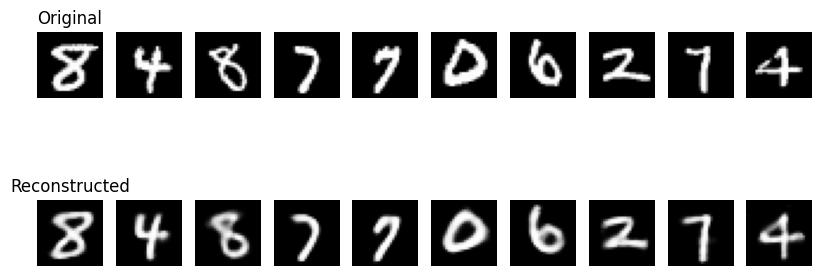

In [17]:
# 5. Evaluate
print("reconstructing...")
X_test_reconstructed = autoencoder.forward(X_test[:1000]) # Predict on a subset to save memory if needed

# 6. Visualize
n_samples = 10
plt.figure(figsize=(10, 4))
for i in range(n_samples):
    # Original
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Original')

    # Reconstructed
    plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(X_test_reconstructed[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Reconstructed')
plt.show()